<a href="https://colab.research.google.com/github/vlozg/houseprice_predict/blob/main/DA_houseprice_ver5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phiên bản này thêm các feature mới bằng cách cộng một số feature với nhau

# Tải dữ liệu.

In [ ]:
#personal url https://drive.google.com/file/d/1Xn-aobJLKAq9APYOIENj4kYpk7Ox0NQH/view?usp=sharing
!gdown --id 1Xn-aobJLKAq9APYOIENj4kYpk7Ox0NQH
# -o để force overwrite
!unzip -o house-prices-advanced-regression-techniques.zip

Downloading...
From: https://drive.google.com/uc?id=1Xn-aobJLKAq9APYOIENj4kYpk7Ox0NQH
To: /content/house-prices-advanced-regression-techniques.zip
100% 204k/204k [00:00<00:00, 13.7MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# Tải kết quả tập test
# Personal url https://drive.google.com/file/d/12LFeaeW9QJpEJPUAGxEipEh7h9rY66HU/view?usp=sharing
!gdown --id 12LFeaeW9QJpEJPUAGxEipEh7h9rY66HU

Downloading...
From: https://drive.google.com/uc?id=12LFeaeW9QJpEJPUAGxEipEh7h9rY66HU
To: /content/test_result.csv
100% 17.4k/17.4k [00:00<00:00, 15.6MB/s]


# Import thư viện và các thiết lập cần thiết

In [ ]:
#@title Supress scikit-learn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_log_error, make_scorer

# Tiền xử lý
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Thư viện scikit-learn cho học máy
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# Các mô hình máy học tuyến tính
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, Lasso

# Mô hình phi tuyến
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, VotingRegressor

from sklearn.model_selection import GridSearchCV

# Mô hình xgb
import xgboost as xgb

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
np.random.seed(1)

# 1.Khám phá dữ liệu

## 1.1 Kích thước các tập

###1.1.1 Tập train

In [ ]:
data_df = pd.read_csv('train.csv', index_col=0)
data_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Trong phần này nhóm khám phá sơ bộ dữ liệu để xác định các vấn đề có thể gặp phải, cũng như có thể xác hiểu rõ hơn về bài toán sẽ giải quyết.

Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [ ]:
# Số dòng X cột của dữ liệu train
data_df.shape

(1460, 80)

### 1.1.2 Tập test

In [ ]:
test_X = pd.read_csv('test.csv', index_col=0)
test_y = pd.read_csv('test_result.csv', index_col=0)['SalePrice']
test_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# Số dòng X cột của dữ liệu test
test_X.shape

(1459, 79)

## 1.2 Khám phá các cột (thuộc tính) của dữ liệu

### 1.2.1 Mỗi cột có ý nghĩa gì?

In [ ]:
with open('data_description.txt', 'r') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Qua mô tả, nhóm có các nhận xét sau:
- Cần lưu ý tại các cột sau vì việc thiếu dữ liệu của các cột này là có chủ đích:
  - `Alley`: kiểu đường hiểm mà căn hộ tiếp xúc => Không tiếp xúc đường hẻm thì sẽ để trống.
  - `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`: các thuộc tính liên quan tới tầng hầm của căn hộ => Không có tầng hầm sẽ để trống.
  - `FireplaceQu`: chất lượng lò sưởi => Không có lò sưởi sẽ để trống.
  - `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`: thuộc tính liên quan tới garage => Không có garage sẽ để trống.
  - `PoolQC`: chất lượng hồ bơi => Không có hồ bơi sẽ để trống.
  - `Fence`: chất lượng hàng rào => Không có hàng rào sẽ để trống.
  - `MiscFeature`: một số tiện nghi khác của căn hộ mà không được liệt kê bởi các thuộc tính trong bảng => Không có sẽ để trống.
- Có một số thuộc tính có dạng multiple choice -> cần lưu ý khi onehot

Các kiểu dữ liệu có trong bảng

In [ ]:
data_df.dtypes.unique().tolist()

[dtype('int64'), dtype('O'), dtype('float64')]

Như vậy trong bảng có xen kẽ giữa 2 kiểu dữ liệu: categorical (phân loại) và numeric (số).

### 1.2.2 Thống kê sơ bộ cho các cột

In [ ]:
cat_cols = data_df.dtypes.index[ data_df.dtypes == 'O' ].tolist()
num_cols = data_df.dtypes.index[ data_df.dtypes != 'O' ].tolist()
num_cols.remove('SalePrice')

Thống kê cho các cột có kiểu numeric:



In [ ]:
data_df[num_cols].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Thống kê cho các cột có kiểu categorical:

In [ ]:
data_df[cat_cols].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


## 1.3 Khám phá cột giá nhà

In [ ]:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

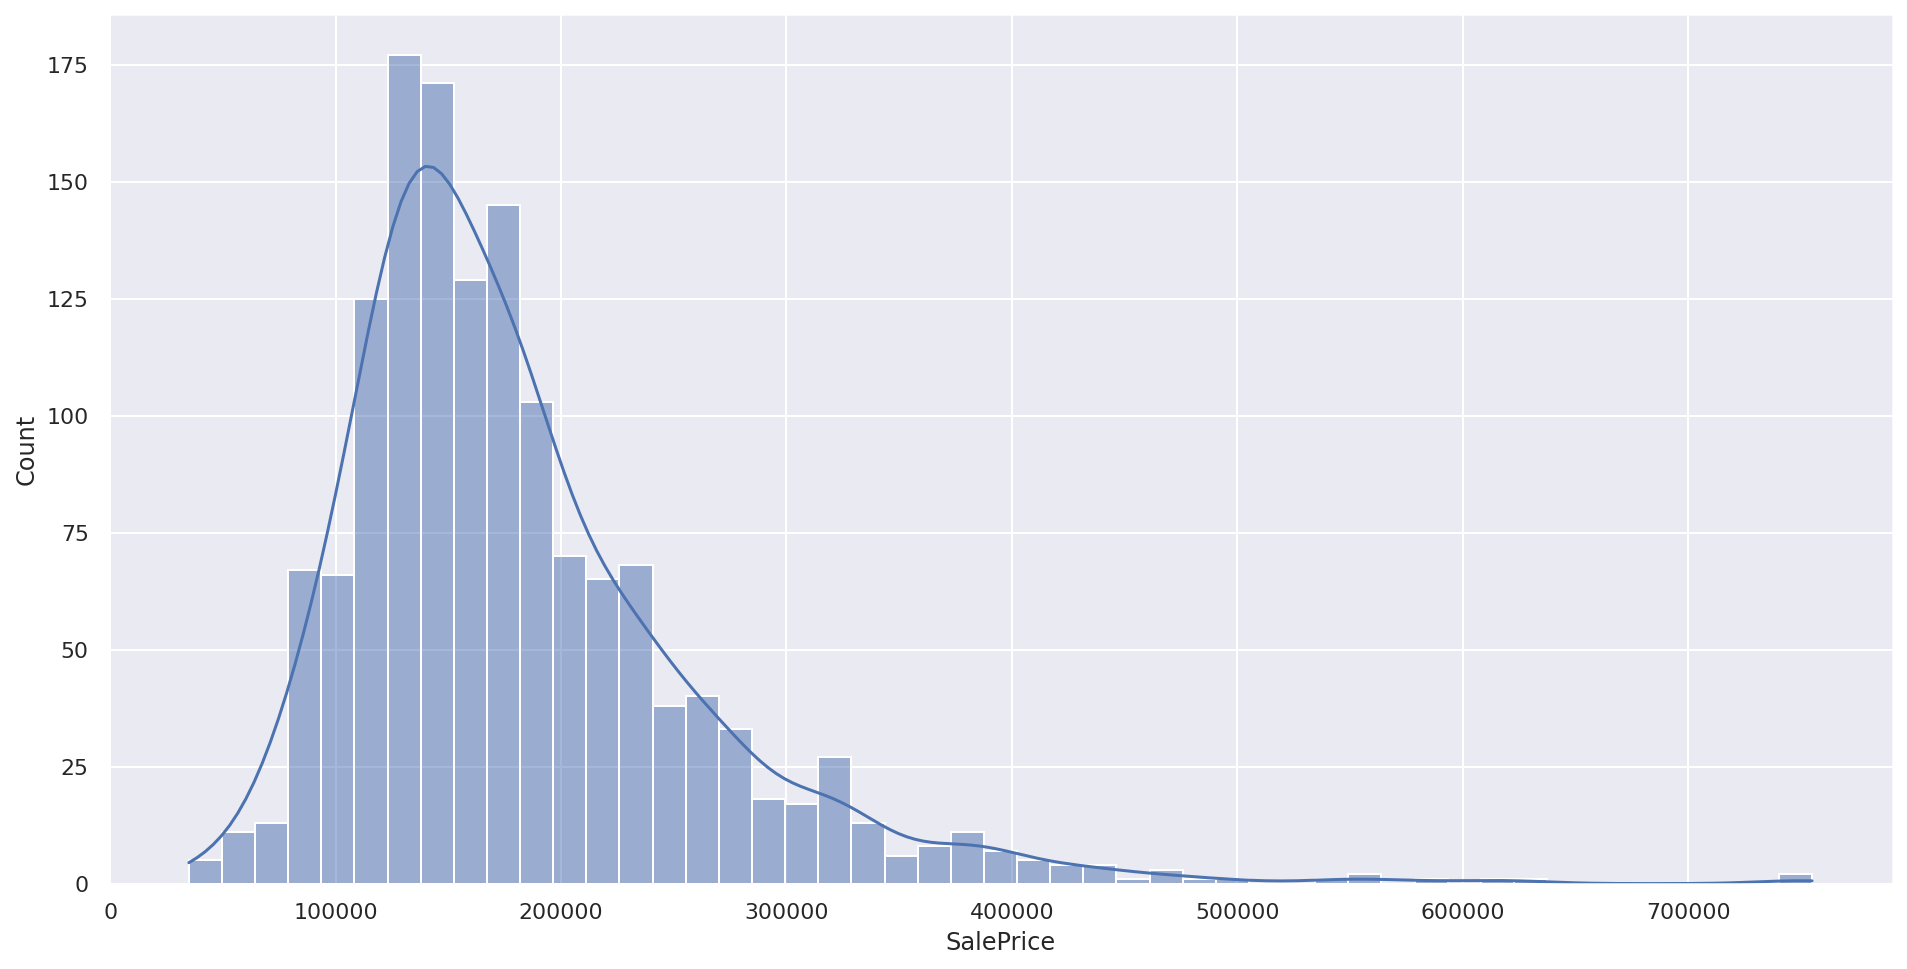

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(data_df['SalePrice'],kde=True)

In [ ]:
print("Skewness: ",round(data_df['SalePrice'].skew(),4))
print("Kurtosis: ",round(data_df['SalePrice'].kurt(),4))

Skewness:  1.8829
Kurtosis:  6.5363


## 1.4 Khám phá dữ liệu thiếu

In [ ]:
missing = data_df.isnull().sum()
missing = missing[missing > 0]
missing_stats = pd.DataFrame({
  'Column Name': missing.index,
  'Count': missing.to_list(),
  'Ratio': np.round(missing/data_df.shape[0]*100,2).to_list()  
})

In [ ]:
cm = sns.light_palette("red", as_cmap=True)
missing_stats.style.background_gradient(cmap=cm)

,Column Name,Count,Ratio
0,LotFrontage,259,17.740000
1,Alley,1369,93.770000
2,MasVnrType,8,0.550000
3,MasVnrArea,8,0.550000
4,BsmtQual,37,2.530000
5,BsmtCond,37,2.530000
6,BsmtExposure,38,2.600000
7,BsmtFinType1,37,2.530000
8,BsmtFinType2,38,2.600000
9,Electrical,1,0.070000


Text(0.5, 0, 'Missing Count')

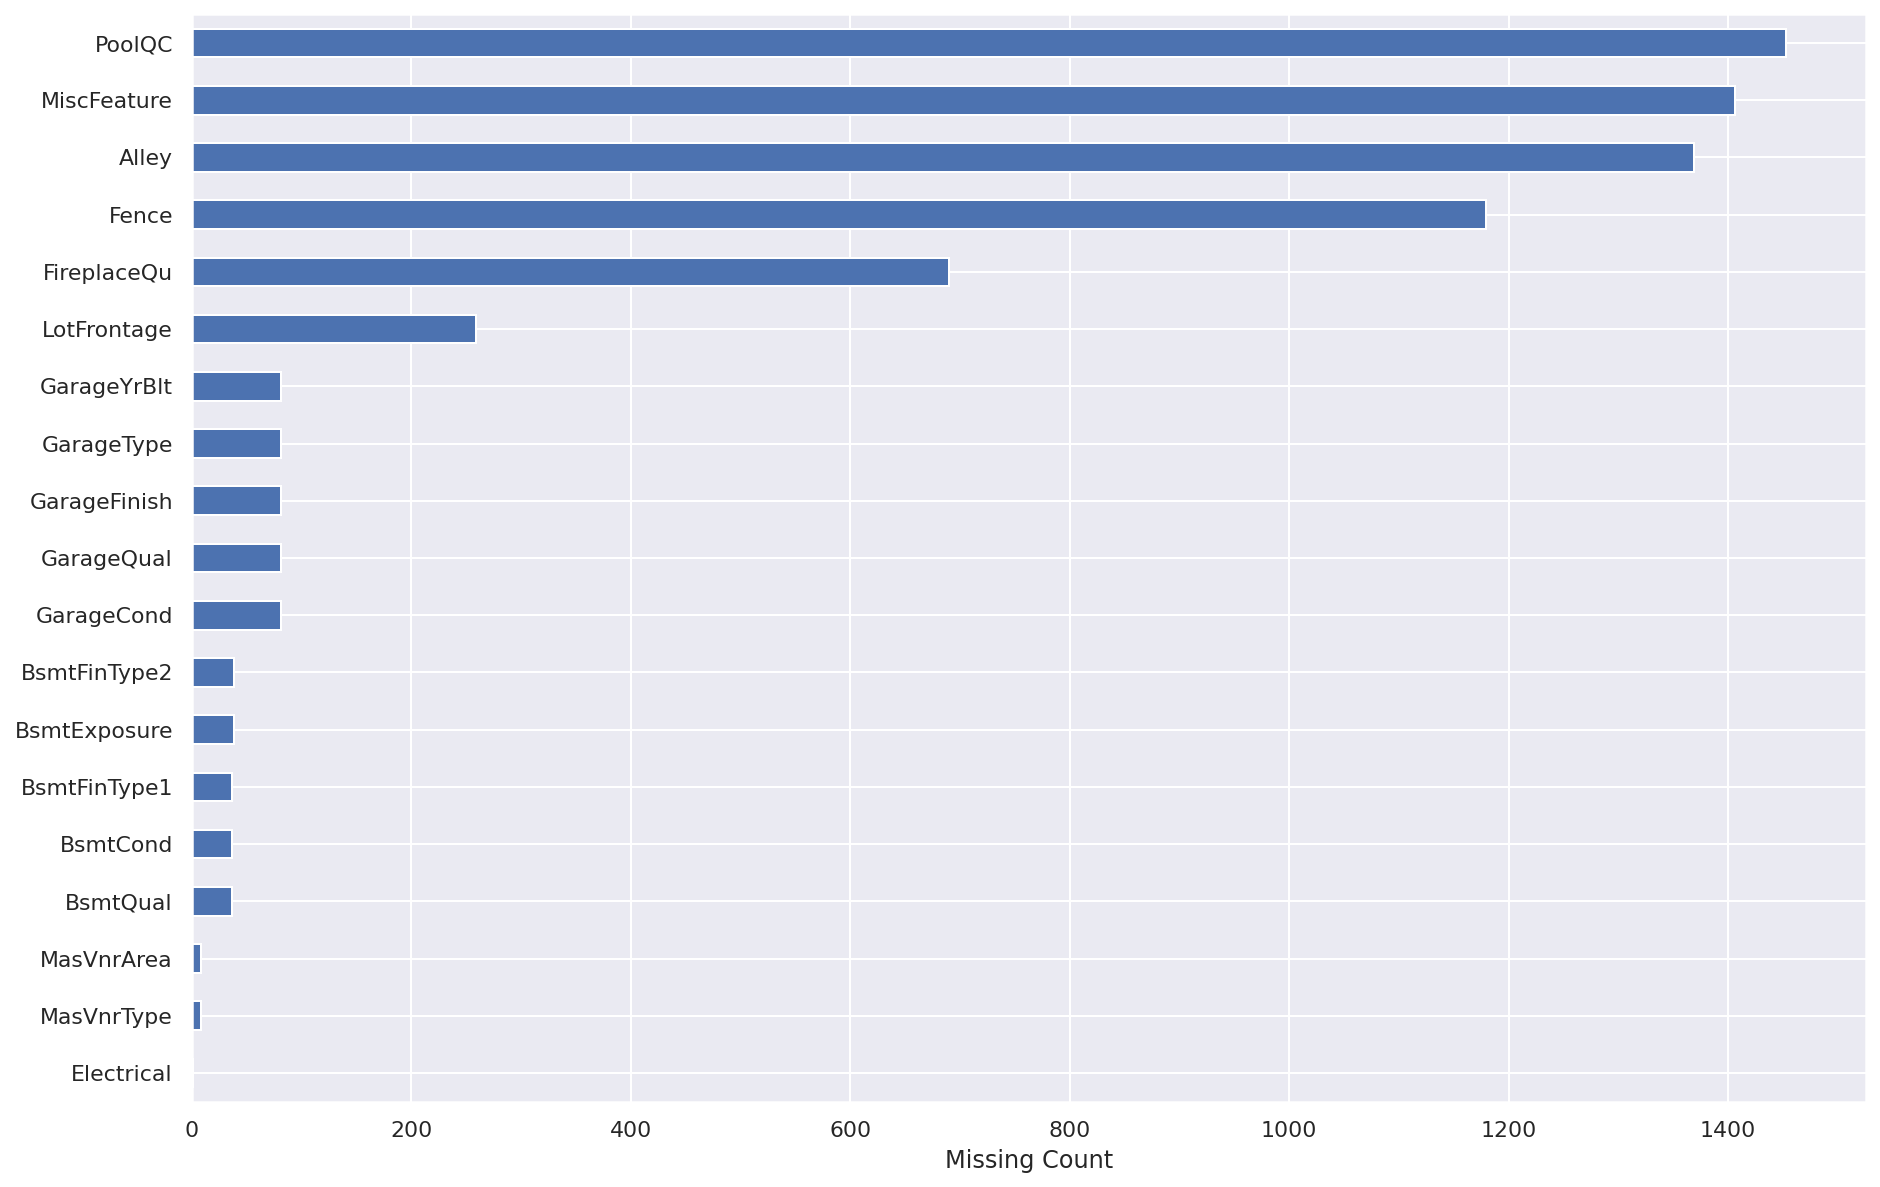

In [ ]:
ax = missing.sort_values().plot.barh(figsize=(15,10))
ax.set_xlabel('Missing Count')

Dựa vào những nhận xét từ file mô tả dữ liệu, những dữ liệu thiếu ở đây hầu như đều có chủ đích. Tuy nhiên có một số cột sau không được đề cập ở trên lại xuất hiện:
- `LotFrontage`
- `MasVnrType`, `MasVnrArea`
- `Electrical`

# 2.Preprocess

## 2.0 New feature

In [ ]:
data_df['YrBltAndRemod']=data_df['YearBuilt']+data_df['YearRemodAdd']
data_df['TotalSF']=data_df['TotalBsmtSF'] + data_df['1stFlrSF'] + data_df['2ndFlrSF']

data_df['Total_sqr_footage'] = (data_df['BsmtFinSF1'] + data_df['BsmtFinSF2'] +
                                 data_df['1stFlrSF'] + data_df['2ndFlrSF'])

data_df['Total_Bathrooms'] = (data_df['FullBath'] + (0.5 * data_df['HalfBath']) +
                               data_df['BsmtFullBath'] + (0.5 * data_df['BsmtHalfBath']))

data_df['Total_porch_sf'] = (data_df['OpenPorchSF'] + data_df['3SsnPorch'] +
                              data_df['EnclosedPorch'] + data_df['ScreenPorch'] +
                              data_df['WoodDeckSF'])

# simplified features
data_df['haspool'] = data_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_df['has2ndfloor'] = data_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data_df['hasgarage'] = data_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_df['hasbsmt'] = data_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_df['hasfireplace'] = data_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
test_X['YrBltAndRemod']=test_X['YearBuilt']+test_X['YearRemodAdd']
test_X['TotalSF']=test_X['TotalBsmtSF'] + test_X['1stFlrSF'] + test_X['2ndFlrSF']

test_X['Total_sqr_footage'] = (test_X['BsmtFinSF1'] + test_X['BsmtFinSF2'] +
                                 test_X['1stFlrSF'] + test_X['2ndFlrSF'])

test_X['Total_Bathrooms'] = (test_X['FullBath'] + (0.5 * test_X['HalfBath']) +
                               test_X['BsmtFullBath'] + (0.5 * test_X['BsmtHalfBath']))

test_X['Total_porch_sf'] = (test_X['OpenPorchSF'] + test_X['3SsnPorch'] +
                              test_X['EnclosedPorch'] + test_X['ScreenPorch'] +
                              test_X['WoodDeckSF'])

# simplified features
test_X['haspool'] = test_X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_X['has2ndfloor'] = test_X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_X['hasgarage'] = test_X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_X['hasbsmt'] = test_X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test_X['hasfireplace'] = test_X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## 2.1 Log và Exp transformation

In [ ]:
test_y = np.log1p(test_y)
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])
data_df["SalePrice"]

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [ ]:
#biến đổi log cho dữ liệu số bị skewed
numeric_feats = data_df.dtypes[data_df.dtypes != "object"].index

skewed_feats = data_df[numeric_feats].apply(lambda x: skew(x.dropna())) 
skewed_feats_pos = skewed_feats[(skewed_feats > 0.75)]
skewed_feats_neg = skewed_feats[(skewed_feats < -0.75)]

skewed_feats_pos = skewed_feats_pos.index
skewed_feats_neg = skewed_feats_neg.index

data_df[skewed_feats_pos] = np.log1p(data_df[skewed_feats_pos])
data_df[skewed_feats_neg] = np.expm1(data_df[skewed_feats_neg])
test_X[skewed_feats_pos] = np.log1p(test_X[skewed_feats_pos])
test_X[skewed_feats_neg] = np.expm1(test_X[skewed_feats_neg])

## 2.2 Tách tập


In [ ]:
data_X = data_df.drop('SalePrice', axis=1)
data_y = data_df['SalePrice']

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(data_X, data_y,test_size=0.3)
train_X.shape, val_X.shape

((1022, 89), (438, 89))

## 2.3 Xây dựng pipeline

In [ ]:
mul_cols = ['Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'BsmtFinType2']
for col in mul_cols:
  cat_cols.remove(col)

Onehot cho dữ liệu categorical

In [ ]:
class OneHotEncoderM(TransformerMixin):
    def __init__(self, *args, **kwargs):
      self.dummy_value = 'MissingValue'
      self.imputer = SimpleImputer(strategy='constant', fill_value=self.dummy_value)
      self.encoder = OneHotEncoder(*args, **kwargs)

    def fit(self, x, y=0):
      self.encoder.fit(self.imputer.fit_transform(x))
      # Remove dummy value from dict
      self.encoder.categories_ = [arr[arr != self.dummy_value] for arr in self.encoder.categories_]
      return self
      
    def transform(self, x, y=0):
      return self.encoder.transform(x)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MissingValue')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

Onehot đặc biệt cho cột dạng multiple choice

In [ ]:
class MultiHotEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
      self.dummy_value = 'zzMissingzz'
      self.encoder = MultiLabelBinarizer(*args, **kwargs)

    def fit(self, x, y=0):
      self.encoder.fit(x.fillna(self.dummy_value).values)
      # Remove dummy value from dict
      self.encoder.classes_ = self.encoder.classes_[self.encoder.classes_ != self.dummy_value]
      # Remove cached value
      self.encoder._cached_dict = None
      return self
      
    def transform(self, x, y=0):
      return self.encoder.transform(x.values)

multilabel_transformer =  Pipeline(steps=[
    ('multilabel',MultiHotEncoder())
])

Fill dữ liệu thiếu bằng mean cho numeric

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_cols),
        ('multi_label', multilabel_transformer, mul_cols),
        ('categorical', categorical_transformer, cat_cols)
        ])

preprocess_pipeline=Pipeline(steps=[('preprocessor', preprocessor)])
#,
#                                   ('scaler', StandardScaler(with_mean=True,with_std=True))])

# 3.Mô hình hóa

## 3.1 Thử nghiệm các mô hình

#### Hàm thống kê độ lỗi

In [ ]:
#@title Hàm RSMLE
def root_MSLE(y_true, y_pred):
  _y_pred = y_pred
  _y_pred[_y_pred < 0] = 0
  return mean_squared_log_error(y_true, _y_pred)**(1/2)

In [ ]:
#@title Hàm thống kê độ lỗi
def error_stats(y, y_pred):
  df = pd.DataFrame({'Actual': np.expm1(y), 'Predicted':np.expm1(y_pred)})
  df['Absolute Error']=df['Actual']-df['Predicted']
  df['Relative Error']=(abs(df['Absolute Error'])/df['Actual'])*100
  MAPE = np.round(df['Relative Error'].mean(), 4)
  RMSLE = root_MSLE(np.expm1(y), np.expm1(y_pred))
  return (df, MAPE, RMSLE)

In [ ]:
#@title Hàm TestModel
def TestModel(model):
  test_pred = model.predict(test_X)
  res_df, MAPE, RMSLE = error_stats(test_y, test_pred)
  print(f'RMSLE: {RMSLE}\n\
  MAPE: {MAPE}')

def TestModel_noprep(model, prep_pipe):
  p_test_X = prep_pipe.transform(test_X)
  test_pred = model.predict(p_test_X)
  res_df, MAPE, RMSLE = error_stats(test_y, test_pred)
  print(f'RMSLE: {RMSLE}\n\
  MAPE: {MAPE}')

### 3.1.1 Gradient Boosting

In [ ]:
loss=['ls','huber']
alpha=[0.4,0.5,0.7,0.8,0.9,0.95,0.99]
gbr_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [ ]:
#@markdown Thử parameter
%%capture
min=float('inf')
for iter_loss in loss:
  for iter_alpha in alpha:
    gbr = make_pipeline(preprocess_pipeline,
                        GradientBoostingRegressor(loss=iter_loss, alpha=iter_alpha, 
                                max_depth=4, n_estimators=100,random_state=22))
    gbr.fit(train_X, train_y)
    val_pred = gbr.predict(val_X)
    err_df_temp, mrE, RMSE = error_stats(val_y, val_pred)
    if RMSE<min:
      min=RMSE
      err_df=err_df_temp
      best_gbr=gbr
    gbr_hyperparam_tuning=gbr_hyperparam_tuning.append({'loss':iter_loss,'alpha':iter_alpha,'MAPE':mrE, 'RMSLE':RMSE},ignore_index=True)

In [ ]:
gbr_hyperparam_tuning

,MAPE,RMSLE,alpha,loss
0,9.7915,0.141879,0.40,ls
1,9.7915,0.141879,0.50,ls
2,9.7915,0.141879,0.70,ls
3,9.7915,0.141879,0.80,ls
4,9.7915,0.141879,0.90,ls
5,9.7915,0.141879,0.95,ls
6,9.7915,0.141879,0.99,ls
7,10.4819,0.153532,0.40,huber
8,10.5157,0.153132,0.50,huber
9,10.3411,0.150458,0.70,huber


In [ ]:
print("Mô hình cho RMSE nhỏ nhất với alpha=0.8 và loss='huber'.\nĐối với tập valuation:")
print(f"Độ sai tương đối trung bình: {gbr_hyperparam_tuning['MAPE'].iloc[10]} %")
print(f"RMSE: {gbr_hyperparam_tuning['RMSLE'].iloc[10]}")
err_df.head()

Mô hình cho RMSE nhỏ nhất với alpha=0.8 và loss='huber'.
Đối với tập valuation:
Độ sai tương đối trung bình: 9.6839 %
RMSE: 0.140116826566477


,Actual,Predicted,Absolute Error,Relative Error
Id,,,,
259,231500.0,200595.427808,30904.572192,13.349707
268,179500.0,164710.314046,14789.685954,8.239379
289,122000.0,118621.198555,3378.801445,2.769509
650,84500.0,78293.283609,6206.716391,7.345226
1234,142000.0,144902.819264,-2902.819264,2.044239


In [ ]:
best_gbr.fit(data_X, data_y)
TestModel(best_gbr)

RMSLE: 0.13300378005590377
  MAPE: 8.9856


In [ ]:
df=pd.DataFrame({'SalePrice':np.expm1(best_gbr.predict(test_X))})
df.index+=1461
df.reset_index(inplace=True)
df.rename({'index':'Id'},inplace=True,axis=1)
df.to_csv('gbr_final.csv',index=False)

### 3.1.2 Ridge

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
ridge_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [ ]:
#@markdown Thử parameter
%%capture
min=float('inf')
for solv in solver:
  for iter_alpha in alphas:
    ridge = make_pipeline(preprocess_pipeline,
                          Ridge(alpha=iter_alpha,tol=0.1,normalize=True,solver=solv))
    ridge.fit(train_X, train_y)
    val_pred = ridge.predict(val_X)
    err_df_temp, mrE, RMSE = error_stats(val_y, val_pred)
    if RMSE<min:
      best_solver=solv
      best_alpha=iter_alpha
      min=RMSE
      err_df=err_df_temp
      best_ridge=ridge
    ridge_hyperparam_tuning = ridge_hyperparam_tuning.append({'solver':solv,'alpha':iter_alpha,'MAPE':mrE, 'RMSLE':RMSE},ignore_index=True)

In [ ]:
ridge_hyperparam_tuning.iloc[0:20]

,MAPE,RMSLE,alpha,solver
0,9.7477,0.133193,0.05,auto
1,9.8142,0.134210,0.10,auto
2,10.0802,0.138480,0.30,auto
3,10.8642,0.150849,1.00,auto
4,12.7309,0.177566,3.00,auto
5,14.3530,0.198954,5.00,auto
6,17.6716,0.239318,10.00,auto
7,20.1418,0.267935,15.00,auto
8,24.8746,0.319068,30.00,auto
9,28.1607,0.352821,50.00,auto


In [ ]:
print("Mô hình cho RMSE nhỏ nhất với alpha = ",best_alpha," và solver = ",best_solver,".\nĐối với tập valuation:")
print(f"Độ sai tương đối trung bình: {ridge_hyperparam_tuning['MAPE'].iloc[11]} %")
print(f"RMSE: {ridge_hyperparam_tuning['RMSLE'].iloc[11]}")
err_df.head()

Mô hình cho RMSE nhỏ nhất với alpha =  0.05  và solver =  svd .
Đối với tập valuation:
Độ sai tương đối trung bình: 9.7477 %
RMSE: 0.13319348301352998


,Actual,Predicted,Absolute Error,Relative Error
Id,,,,
259,231500.0,218939.877466,12560.122534,5.425539
268,179500.0,167847.561361,11652.438639,6.491609
289,122000.0,111014.286737,10985.713263,9.004683
650,84500.0,78913.718788,5586.281212,6.610984
1234,142000.0,130326.322870,11673.677130,8.220899


In [ ]:
best_ridge.fit(data_X, data_y)
TestModel(best_ridge)

RMSLE: 0.13253347205743052
  MAPE: 8.7729


In [ ]:
df=pd.DataFrame({'SalePrice':np.expm1(best_ridge.predict(test_X))})
df.index+=1461
df.reset_index(inplace=True)
df.rename({'index':'Id'},inplace=True,axis=1)
df.to_csv('ridge_final.csv',index=False)

### 3.1.3 Lasso

In [ ]:
alphas = [0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001]
lasso_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [ ]:
#@markdown Thử parameter
%%capture
min=float('inf')
for iter_alpha in alphas:
  lasso = make_pipeline(preprocess_pipeline,
                        Lasso(alpha=iter_alpha,random_state=22,max_iter=10000,tol=0.01))
  lasso.fit(train_X, train_y)
  if iter_alpha==0:
    linear_regression=lasso
  val_pred = lasso.predict(val_X)
  err_df_temp, mrE, RMSE = error_stats(val_y, val_pred)
  if RMSE<min:
    min=RMSE
    err_df=err_df_temp
    best_lasso=lasso
  lasso_hyperparam_tuning = lasso_hyperparam_tuning.append({'alpha':iter_alpha,'MAPE':mrE, 'RMSLE':RMSE},ignore_index=True)

In [ ]:
lasso_hyperparam_tuning

,MAPE,RMSLE,alpha
0,14.5673,0.194905,0.0500
1,12.6348,0.173763,0.0200
2,11.9412,0.165825,0.0100
3,10.8432,0.151403,0.0050
4,10.0511,0.141648,0.0020
5,9.7432,0.138288,0.0010
6,9.3272,0.132156,0.0005
7,9.1652,0.127495,0.0002
8,9.2071,0.127190,0.0001


In [ ]:
print("Mô hình cho RMSE nhỏ nhất với alpha=0.0001.\nĐối với tập valuation:")
print(f"Độ sai tương đối trung bình: {lasso_hyperparam_tuning['MAPE'].iloc[8]} %")
print(f"RMSE: {lasso_hyperparam_tuning['RMSLE'].iloc[8]}")
err_df.head()

Mô hình cho RMSE nhỏ nhất với alpha=0.0001.
Đối với tập valuation:
Độ sai tương đối trung bình: 9.2071 %
RMSE: 0.12719001286386644


,Actual,Predicted,Absolute Error,Relative Error
Id,,,,
259,231500.0,215601.236928,15898.763072,6.867716
268,179500.0,182783.882208,-3283.882208,1.829461
289,122000.0,111142.373727,10857.626273,8.899694
650,84500.0,80501.132201,3998.867799,4.732388
1234,142000.0,127149.748674,14850.251326,10.457923


In [ ]:
best_lasso.fit(data_X, data_y)
TestModel(best_lasso)

RMSLE: 0.12856391402579997
  MAPE: 8.4267


In [ ]:
df=pd.DataFrame({'SalePrice':np.expm1(best_lasso.predict(test_X))})
df.index+=1461
df.reset_index(inplace=True)
df.rename({'index':'Id'},inplace=True,axis=1)
df.to_csv('lasso_final.csv',index=False)

### 3.1.4 XGB

In [ ]:
lns = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
xgb_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [ ]:
p_train_X = preprocess_pipeline.fit_transform(train_X)
p_val_X = preprocess_pipeline.transform(val_X)
p_test_X = preprocess_pipeline.transform(test_X)

In [ ]:
#@markdown Thử parameter
min=float('inf')
for iter_ln in lns:
  my_model = xgb.XGBRegressor(n_estimators=1000,learning_rate=iter_ln,random_state=22,objective='reg:squarederror',max_depth=2)
  my_model.fit(p_train_X, train_y, early_stopping_rounds=100, 
             eval_set=[(p_val_X, val_y)],verbose=False)
  val_pred = my_model.predict(p_val_X)
  err_df_temp, mrE, RMSE = error_stats(val_y, val_pred)
  if RMSE<min:
    min=RMSE
    err_df=err_df_temp
    best_xgb=my_model
  xgb_hyperparam_tuning = xgb_hyperparam_tuning.append({'learning_rates':iter_ln,'MAPE':mrE, 'RMSLE':RMSE},ignore_index=True)

In [ ]:
xgb_hyperparam_tuning

,MAPE,RMSLE,learning_rates
0,10.4234,0.144995,0.500
1,9.2235,0.131807,0.200
2,9.3413,0.135771,0.100
3,9.2893,0.133863,0.050
4,9.7404,0.139295,0.020
5,10.4074,0.149440,0.010
6,13.3124,0.182628,0.005


In [ ]:
print("Mô hình cho RMSE nhỏ nhất với learning_rate = 0.2.\nĐối với tập valuation:")
print(f"Độ sai tương đối trung bình: {xgb_hyperparam_tuning['MAPE'].iloc[1]} %")
print(f"RMSE: {xgb_hyperparam_tuning['RMSLE'].iloc[1]}")
err_df.head()

Mô hình cho RMSE nhỏ nhất với learning_rate = 0.2.
Đối với tập valuation:
Độ sai tương đối trung bình: 9.2235 %
RMSE: 0.13180672366593446


,Actual,Predicted,Absolute Error,Relative Error
Id,,,,
259,231500.0,204249.468750,27250.531250,11.771288
268,179500.0,180854.812500,-1354.812500,0.754770
289,122000.0,119965.320312,2034.679688,1.667770
650,84500.0,74420.609375,10079.390625,11.928273
1234,142000.0,137286.562500,4713.437500,3.319322


In [ ]:
best_xgb.fit(np.append(p_train_X,p_val_X,axis=0), np.append(train_y,val_y,axis=0))
TestModel_noprep(best_xgb, preprocess_pipeline)

RMSLE: 0.13641325962154832
  MAPE: 8.8793


In [ ]:
df=pd.DataFrame({'SalePrice':np.expm1(best_xgb.predict(preprocess_pipeline.transform(test_X)))})
df.index+=1461
df.reset_index(inplace=True)
df.rename({'index':'Id'},inplace=True,axis=1)
df.to_csv('xgb_final.csv',index=False)

### 3.1.5 RidgeCV

In [ ]:
best_ridge_cv=make_pipeline(preprocess_pipeline,
                            RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],normalize=True,scoring="neg_mean_squared_error", cv = 5))

In [ ]:
best_ridge_cv.fit(data_X, data_y)
TestModel(best_ridge_cv)

RMSLE: 0.13277257821084065
  MAPE: 8.8637


### 3.1.6 LassoCV


In [ ]:
best_lasso_cv=make_pipeline(preprocess_pipeline,
                            LassoCV(cv=5,alphas=[0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001],tol=0.01,max_iter=10000))

In [ ]:
best_lasso_cv.fit(data_X, data_y)
TestModel(best_lasso_cv)

RMSLE: 0.12398249177813596
  MAPE: 8.2155


GBR     = 0.13326

Lasso   = 0.12719

Ridge   = 0.13319

XGB     = 0.13181

RidgeCV = 0.13312

LassoCV = 0.12398

### 3.1.7 Voting Regressor

In [ ]:
voting_reg = VotingRegressor([('gbr', best_gbr), 
                              ('ridge_cv', best_ridge_cv),
                              ('lasso_cv', best_lasso_cv)])

In [ ]:
voting_reg.fit(data_X, data_y)
TestModel(voting_reg)

RMSLE: 0.12212961373237548
  MAPE: 7.9454


### 3.1.8 Stacking Regressor

In [ ]:
estimators = [('gbr', best_gbr), 
              ('ridge_cv', best_ridge_cv),
              ('lasso_cv', best_lasso_cv)]
stacking_reg = StackingRegressor(estimators=estimators,
                                 final_estimator=GradientBoostingRegressor(loss='huber'))

In [ ]:
stacking_reg.fit(data_X, data_y)
TestModel(stacking_reg)

RMSLE: 0.11982340418098804
  MAPE: 7.8864


# 4. Feature importance

In [ ]:
# Đánh giá feature importance
from sklearn.inspection import permutation_importance

In [ ]:
%%capture
result = permutation_importance(best_lasso_cv, test_X, test_y, scoring='neg_root_mean_squared_error', n_repeats=20)

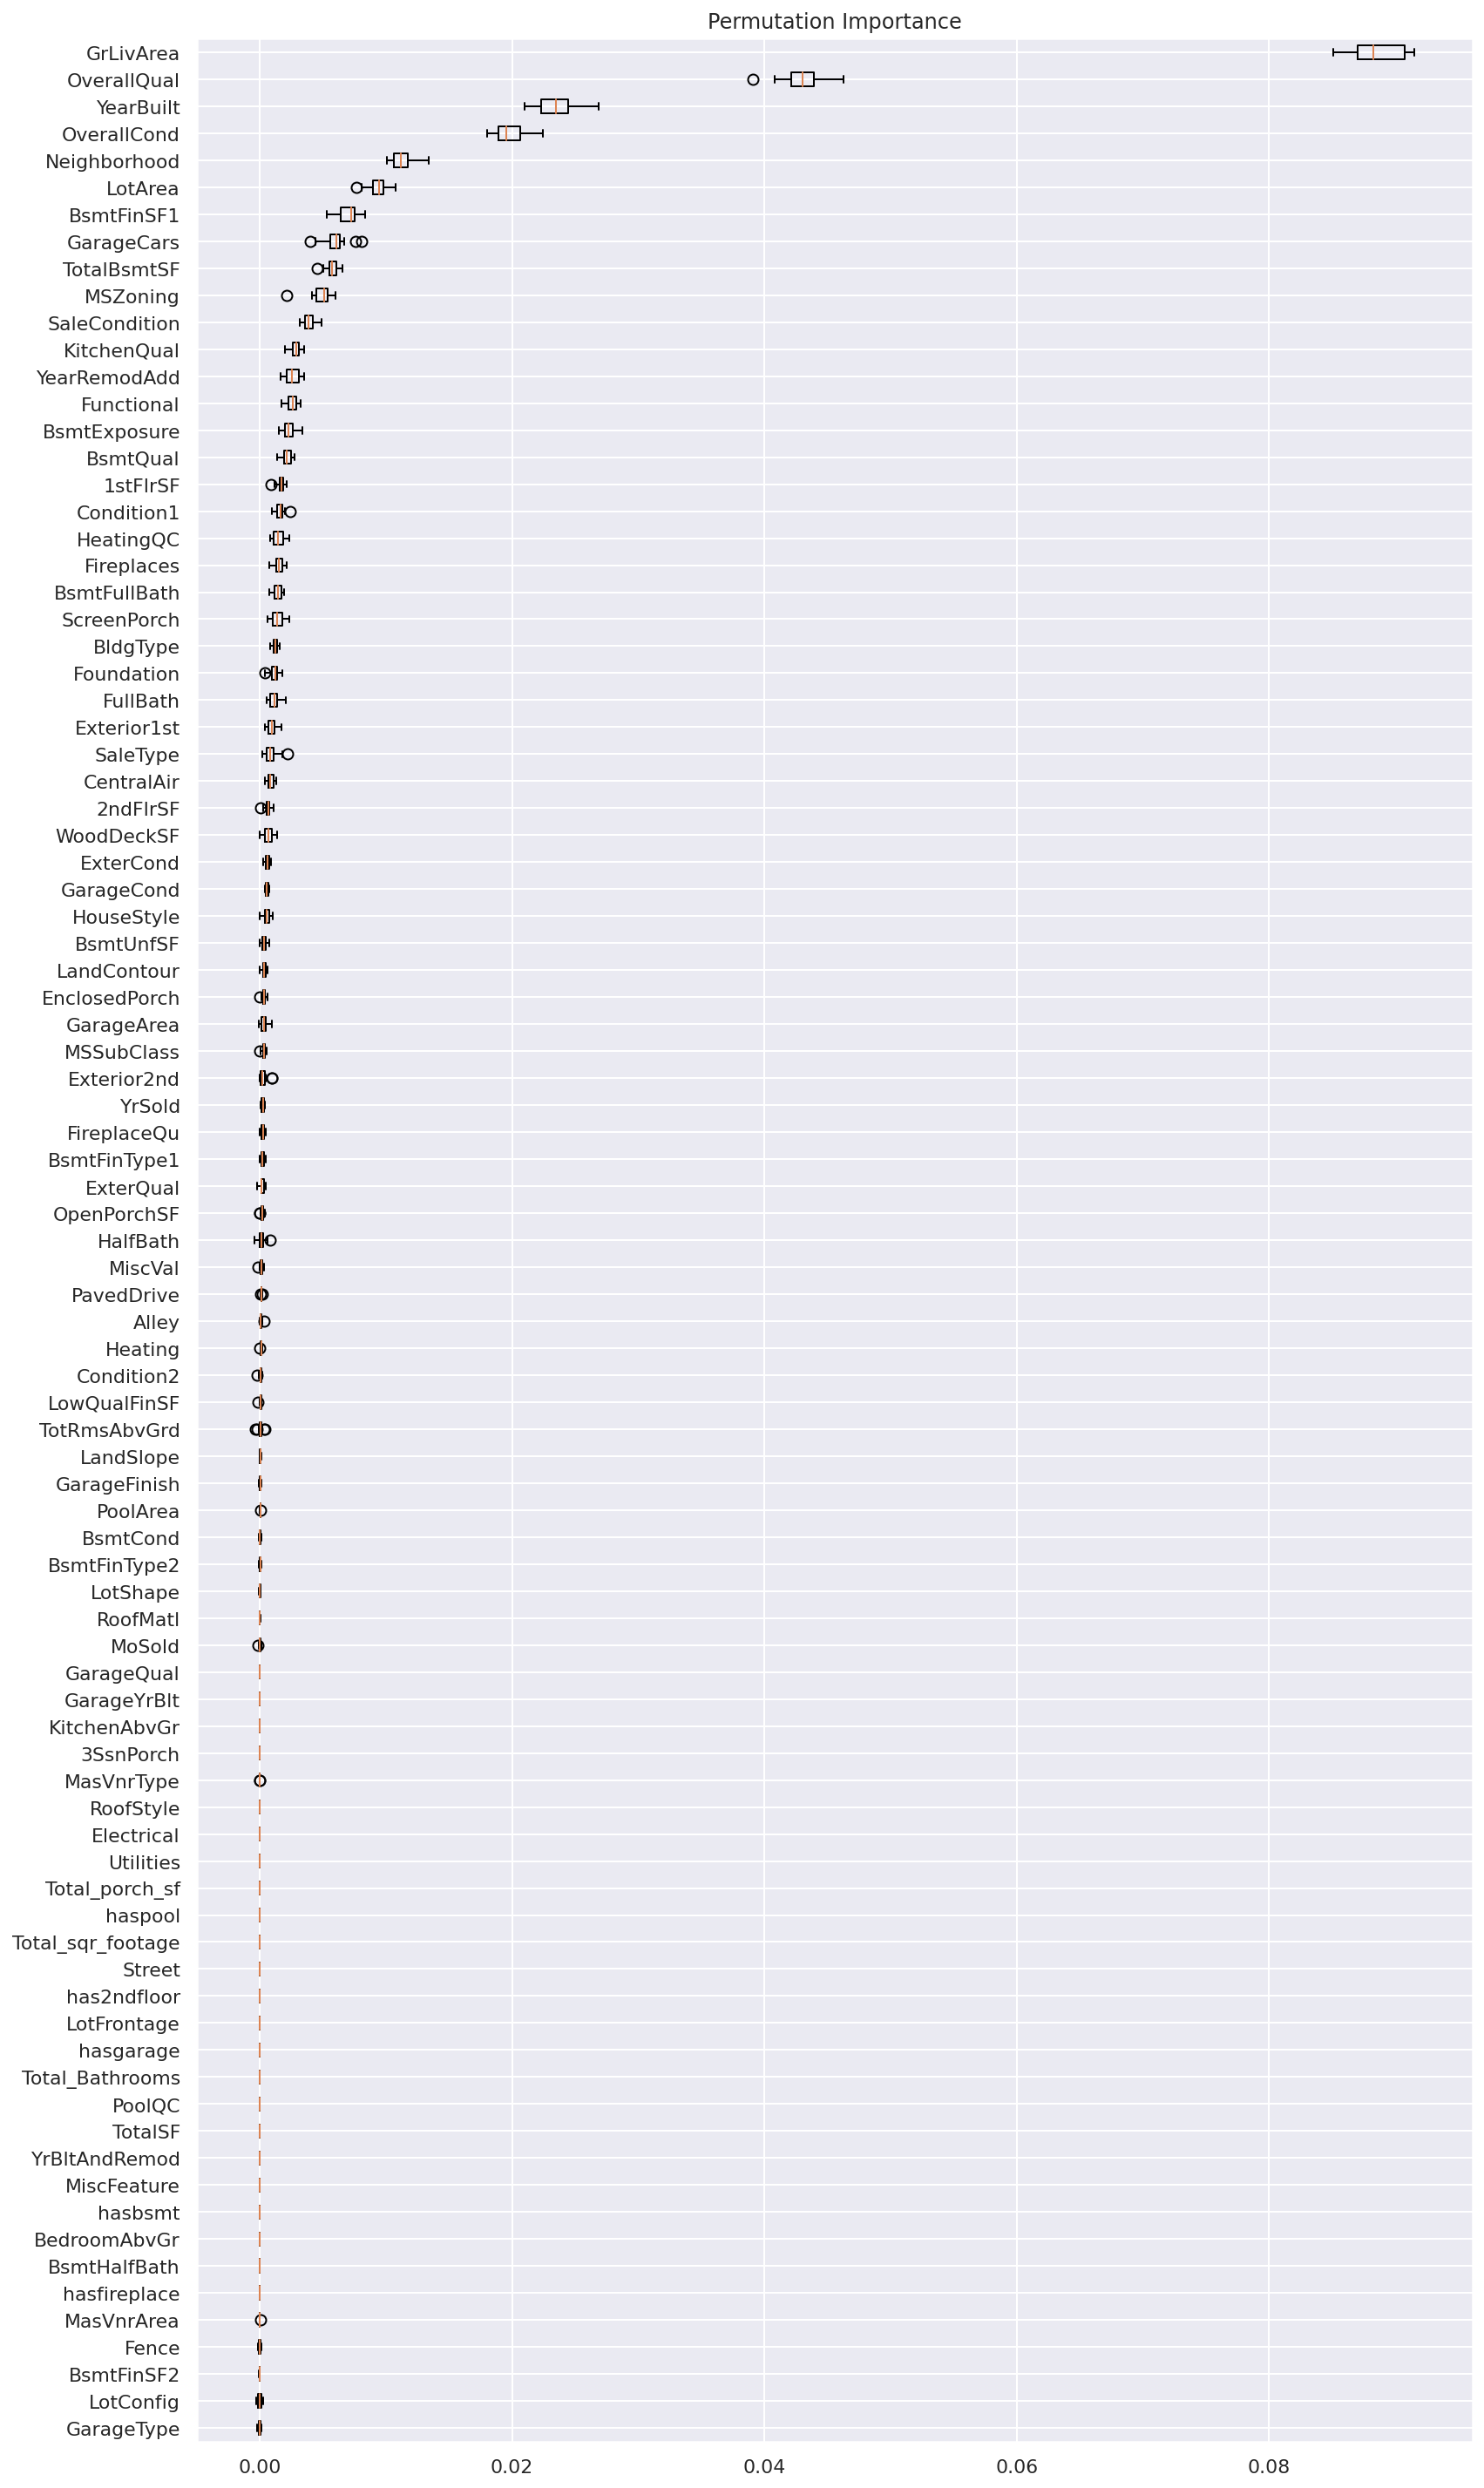

In [ ]:
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(12, 20))
#plt.subplot(1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=data_X.columns[sorted_idx])
plt.title("Permutation Importance")
fig.tight_layout()
plt.show()